### Notebook Setup

In [50]:
! pip install imblearn
! pip install xgboost
! pip install ctgan


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
  Using cached ctgan-0.7.1-py2.py3-none-any.whl (26 kB)


In [51]:
import pandas as pd
import numpy as np

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import classification_report, make_scorer,recall_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.metrics import recall_score
import joblib
# import CTGAN

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [52]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

### Data Read-in

In [53]:
# Path
path = '../processed_data/LIMITED_full_data_2010_2019_2023-03-28 00:54:10.918250.parquet' 
df = pd.read_parquet(path).drop_duplicates()

In [54]:
def get_storm_category(x):
    x = np.round(x)
    if x < 0.05:
        return 1
    elif x > 5:
        return 5
    else:
        return x

In [55]:
df['storm_category'] = df['USA_SSHS'].apply(get_storm_category)

In [56]:
df.rename(columns={'distance_from_cost':'distance_from_coast'}).to_csv('physical_risk_property_pred.csv')

In [57]:
df.head()

,quarter,Year,address,USA_WIND,USA_GUST,USA_SSHS,effective_rent,expose_status_code,hurricane_hit,street_address,city,state,zip,occupancy,prop_rent_growth,sma_rent_growth,quarter_period,rent_decreased,next_efective_rent,distance_from_cost,RISK_SCORE,CFLD_RISKS,HRCN_RISKS,storm_category
0,3Q16,2016,"[10] grayson place, 1600 pullen rd, tallahasse...",68.333333,80.0,1.0,733.0,3,1,1600 pullen rd,Tallahassee,FL,32303,0.8929,0.006711,0.005882,2016-09-30,0,748.0,39.482005,11.908661,2.717984,13.908509,1.0
1,3Q16,2016,"[10] sabal court, 2125 jackson bluff rd, talla...",68.333333,80.0,1.0,655.0,3,1,2125 jackson bluff rd,Tallahassee,FL,32304,0.9453,0.003298,0.005882,2016-09-30,0,690.0,34.844183,11.908661,2.717984,13.908509,1.0
2,3Q16,2016,"[11] capital place at southwood, 2300 bluff oa...",68.333333,80.0,1.0,1233.0,3,1,2300 bluff oak way,Tallahassee,FL,32311,0.9444,0.002880,0.005882,2016-09-30,0,1241.0,30.685704,11.908661,2.717984,13.908509,1.0
3,3Q16,2016,"[11] live oaks at 275, 275 john knox rd, talla...",68.333333,80.0,1.0,786.0,3,1,275 john knox rd,Tallahassee,FL,32303,0.9009,0.000797,0.005882,2016-09-30,1,773.0,37.904028,11.908661,2.717984,13.908509,1.0
4,3Q16,2016,"[12] capital ridge, 3255 capital cir ne, talla...",68.333333,80.0,1.0,707.0,3,1,3255 capital cir ne,Tallahassee,FL,32308,0.8889,0.006706,0.005882,2016-09-30,1,677.0,39.892557,11.908661,2.717984,13.908509,1.0


In [58]:
df.groupby('storm_category').agg(
{"USA_WIND": ['mean', 'min', 'max'],'USA_GUST': ['mean', 'min', 'max']}
)

USA_WIND                            USA_GUST              
                      mean         min         max        mean    min    max
storm_category                                                              
1.0              63.938671   61.000000   81.666667   89.957582   80.0  110.0
2.0              91.337766   86.250000   96.000000  112.925532  110.0  115.0
3.0             102.672214   97.333333  112.333333  125.151286  115.0  135.0
4.0             113.500000  113.500000  113.500000  140.000000  140.0  140.0

In [59]:
df['quarter_num'] = pd.to_numeric(df['quarter'].str[0])

In [60]:
df.columns

Index(['quarter', 'Year', 'address', 'USA_WIND', 'USA_GUST', 'USA_SSHS',
       'effective_rent', 'expose_status_code', 'hurricane_hit',
       'street_address', 'city', 'state', 'zip', 'occupancy',
       'prop_rent_growth', 'sma_rent_growth', 'quarter_period',
       'rent_decreased', 'next_efective_rent', 'distance_from_cost',
       'RISK_SCORE', 'CFLD_RISKS', 'HRCN_RISKS', 'storm_category',
       'quarter_num'],
      dtype='object')

In [61]:
df.shape

(1708, 25)

### Feature Selection

In [62]:
## subsetting only to rows where hurricane_hit = 1

df_subset = df.loc[(df['hurricane_hit'] == 1) & (df.expose_status_code.isin([1,2,3]))]

In [63]:
df_subset['percent_change'] = np.divide(
    df_subset['effective_rent'] - df_subset['next_efective_rent'],
    df_subset['effective_rent']
)

In [64]:
def categorize_percent_change(percent_change):
    if percent_change > (0.035/4):
        return 0
    elif  (0.025/4) < percent_change <= (0.035/4):
        return 1
    else:
        return 2

In [65]:
df_subset['percent_change_category'] = df_subset['percent_change'].apply(categorize_percent_change)

In [66]:
df_subset.head()

,quarter,Year,address,USA_WIND,USA_GUST,USA_SSHS,effective_rent,expose_status_code,hurricane_hit,street_address,city,state,zip,occupancy,prop_rent_growth,sma_rent_growth,quarter_period,rent_decreased,next_efective_rent,distance_from_cost,RISK_SCORE,CFLD_RISKS,HRCN_RISKS,storm_category,quarter_num,percent_change,percent_change_category
0,3Q16,2016,"[10] grayson place, 1600 pullen rd, tallahasse...",68.333333,80.0,1.0,733.0,3,1,1600 pullen rd,Tallahassee,FL,32303,0.8929,0.006711,0.005882,2016-09-30,0,748.0,39.482005,11.908661,2.717984,13.908509,1.0,3,-0.020464,2
1,3Q16,2016,"[10] sabal court, 2125 jackson bluff rd, talla...",68.333333,80.0,1.0,655.0,3,1,2125 jackson bluff rd,Tallahassee,FL,32304,0.9453,0.003298,0.005882,2016-09-30,0,690.0,34.844183,11.908661,2.717984,13.908509,1.0,3,-0.053435,2
2,3Q16,2016,"[11] capital place at southwood, 2300 bluff oa...",68.333333,80.0,1.0,1233.0,3,1,2300 bluff oak way,Tallahassee,FL,32311,0.9444,0.002880,0.005882,2016-09-30,0,1241.0,30.685704,11.908661,2.717984,13.908509,1.0,3,-0.006488,2
3,3Q16,2016,"[11] live oaks at 275, 275 john knox rd, talla...",68.333333,80.0,1.0,786.0,3,1,275 john knox rd,Tallahassee,FL,32303,0.9009,0.000797,0.005882,2016-09-30,1,773.0,37.904028,11.908661,2.717984,13.908509,1.0,3,0.016539,0
4,3Q16,2016,"[12] capital ridge, 3255 capital cir ne, talla...",68.333333,80.0,1.0,707.0,3,1,3255 capital cir ne,Tallahassee,FL,32308,0.8889,0.006706,0.005882,2016-09-30,1,677.0,39.892557,11.908661,2.717984,13.908509,1.0,3,0.042433,0


In [67]:
df_subset = df_subset.loc[:, ~df_subset.columns.isin([
                                 'quarter',
                                 'address',
                                 'Next Effective Rent',
                                 'Rent Difference',
                                 'city',
                                 'state',
                                 'hurricane_hit'])]
df_subset.columns

Index(['Year', 'USA_WIND', 'USA_GUST', 'USA_SSHS', 'effective_rent',
       'expose_status_code', 'street_address', 'zip', 'occupancy',
       'prop_rent_growth', 'sma_rent_growth', 'quarter_period',
       'rent_decreased', 'next_efective_rent', 'distance_from_cost',
       'RISK_SCORE', 'CFLD_RISKS', 'HRCN_RISKS', 'storm_category',
       'quarter_num', 'percent_change', 'percent_change_category'],
      dtype='object')

#### Cleaning up data types and variable names

In [68]:
# df_subset = df_subset.astype({"expose_status_code":'category'})
df_subset = df_subset.rename(columns={'distance_from_cost': 'distance_from_coast',
                                      'Rent Decreased': 'rent_decreased',
                                     }).dropna()

In [69]:
print(df_subset.shape)
print(df_subset.columns)
df_subset.head()

(1708, 22)
Index(['Year', 'USA_WIND', 'USA_GUST', 'USA_SSHS', 'effective_rent',
       'expose_status_code', 'street_address', 'zip', 'occupancy',
       'prop_rent_growth', 'sma_rent_growth', 'quarter_period',
       'rent_decreased', 'next_efective_rent', 'distance_from_coast',
       'RISK_SCORE', 'CFLD_RISKS', 'HRCN_RISKS', 'storm_category',
       'quarter_num', 'percent_change', 'percent_change_category'],
      dtype='object')


,Year,USA_WIND,USA_GUST,USA_SSHS,effective_rent,expose_status_code,street_address,zip,occupancy,prop_rent_growth,sma_rent_growth,quarter_period,rent_decreased,next_efective_rent,distance_from_coast,RISK_SCORE,CFLD_RISKS,HRCN_RISKS,storm_category,quarter_num,percent_change,percent_change_category
0,2016,68.333333,80.0,1.0,733.0,3,1600 pullen rd,32303,0.8929,0.006711,0.005882,2016-09-30,0,748.0,39.482005,11.908661,2.717984,13.908509,1.0,3,-0.020464,2
1,2016,68.333333,80.0,1.0,655.0,3,2125 jackson bluff rd,32304,0.9453,0.003298,0.005882,2016-09-30,0,690.0,34.844183,11.908661,2.717984,13.908509,1.0,3,-0.053435,2
2,2016,68.333333,80.0,1.0,1233.0,3,2300 bluff oak way,32311,0.9444,0.002880,0.005882,2016-09-30,0,1241.0,30.685704,11.908661,2.717984,13.908509,1.0,3,-0.006488,2
3,2016,68.333333,80.0,1.0,786.0,3,275 john knox rd,32303,0.9009,0.000797,0.005882,2016-09-30,1,773.0,37.904028,11.908661,2.717984,13.908509,1.0,3,0.016539,0
4,2016,68.333333,80.0,1.0,707.0,3,3255 capital cir ne,32308,0.8889,0.006706,0.005882,2016-09-30,1,677.0,39.892557,11.908661,2.717984,13.908509,1.0,3,0.042433,0


In [70]:
decreased = df_subset[df_subset.rent_decreased == 1]
not_decreased = df_subset[df_subset.rent_decreased == 0]

In [71]:
print(np.mean(decreased.USA_SSHS), np.mean(not_decreased.USA_SSHS))
print(np.mean(decreased.USA_GUST), np.mean(not_decreased.USA_GUST))
print(np.mean(decreased.USA_WIND), np.mean(not_decreased.USA_WIND))

print(np.mean(decreased.CFLD_RISKS), np.mean(not_decreased.CFLD_RISKS))
print(np.mean(decreased.HRCN_RISKS), np.mean(not_decreased.HRCN_RISKS))
print(np.mean(decreased.expose_status_code), np.mean(not_decreased.expose_status_code))


1.559051724137929 1.6597222222222274
103.94827586206897 105.74468085106383
79.30431034482774 81.45811170212731
13.51098727945675 16.04250949807425
22.05989027840007 27.20288609076888
1.5741379310344827 1.6028368794326242


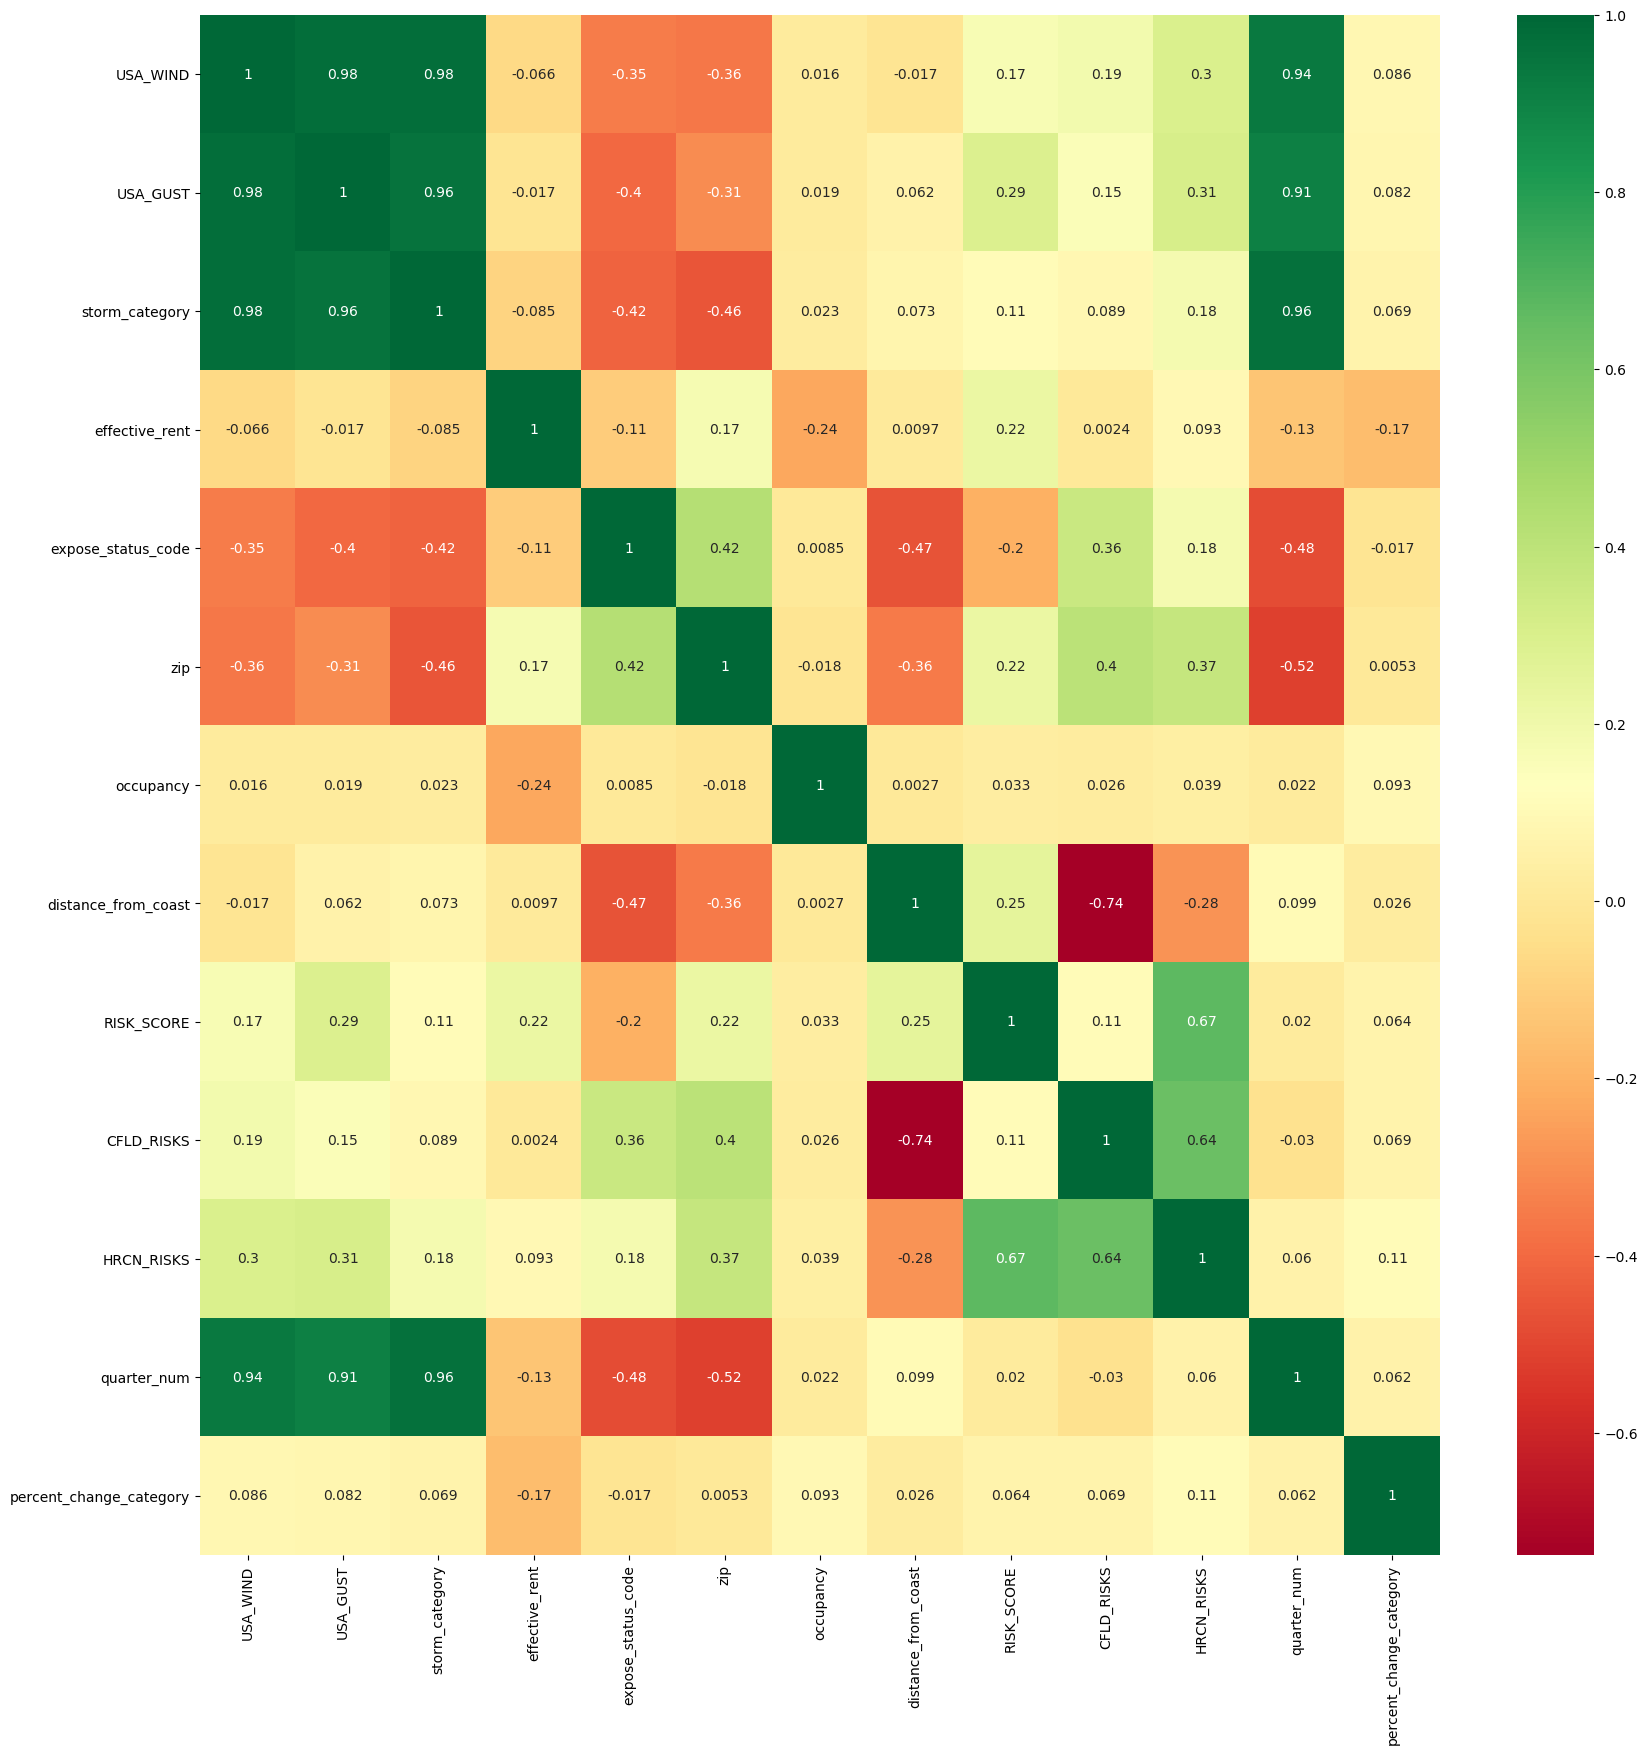

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
df_subset_corr = df_subset[['USA_WIND', 'USA_GUST', 'storm_category', 'effective_rent',
       'expose_status_code', 'zip', 'occupancy',
       'distance_from_coast', 'RISK_SCORE', 'CFLD_RISKS',
       'HRCN_RISKS', 'quarter_num', 'percent_change_category']] 
# y = df_subset['percent_change_category']    #target column i.e price range
#get correlations of each features in dataset
corrmat = df_subset_corr.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_subset_corr[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### EDA 

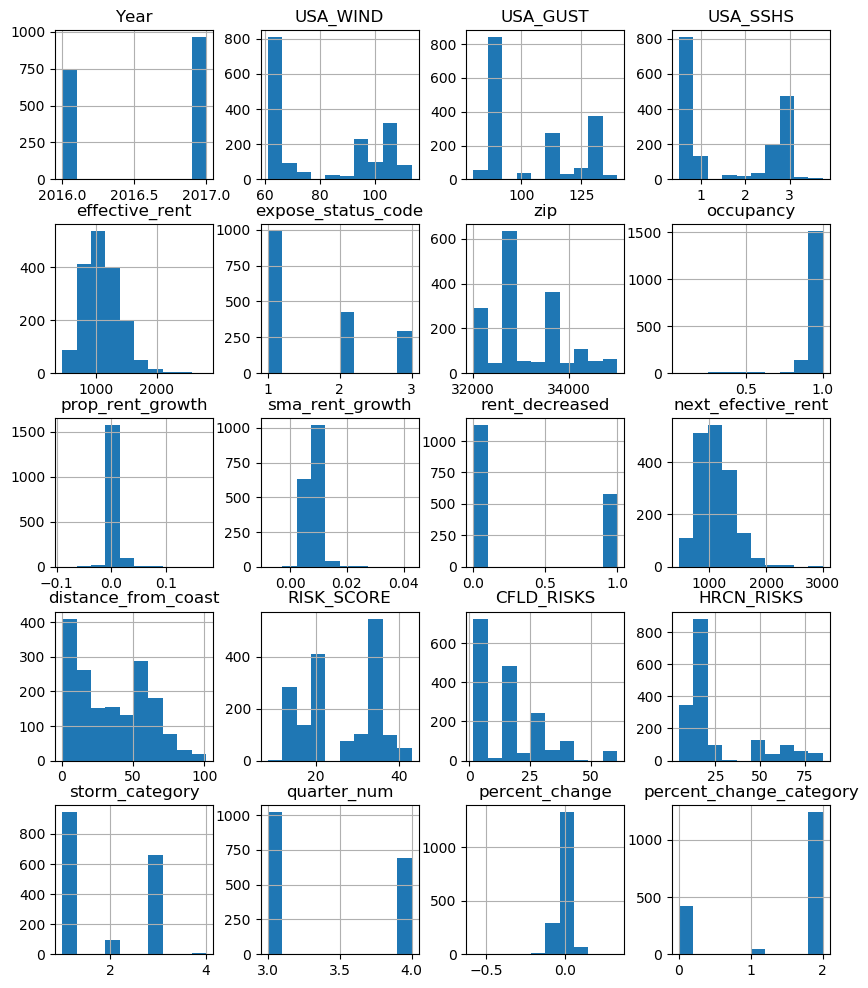

In [73]:
%matplotlib inline
df_subset.hist(figsize=(10,12));

`fed_funds`, `10_yr_inflation`, `5_yr_inflation`, `mortgage`, `delinquency`, `housing_inventory`, `bank_tightening` have no variability. We will be excluding these from the feature set. 

In [74]:
X = df_subset.loc[:, ~df_subset.columns.isin([
    'fed_funds', '10_yr_inflation', '5_yr_inflation',
    'mortgage', 'delinquency', 'housing_inventory',
    'bank_tightening', 
    'rent_decreased', 'percent_change_category'
])]
y = df_subset.loc[:, df_subset.columns.isin(['rent_decreased', 'percent_change_category'])]
y = y['percent_change_category'].ravel()

In [75]:
# df_subset['percent_change_category_name'].value_counts()

In [76]:
df_subset['percent_change_category'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

2    72.5%
0    24.9%
1     2.6%
Name: percent_change_category, dtype: object

In [77]:
numeric_features = [
    "effective_rent", 
    'USA_WIND', 
    'USA_GUST',
    'storm_category',
    'prop_rent_growth', 'sma_rent_growth',
    'expose_status_code',
    'occupancy',
    "distance_from_coast",
    "RISK_SCORE", 
    "CFLD_RISKS",
    "HRCN_RISKS", 
    "quarter_num"
]

In [78]:
numerics = df_subset[numeric_features]

In [79]:
scaled_data = preprocessing.scale(numerics.T) # (measurements - mean)**2 / (total num of measurements)

In [80]:
pca = PCA()
pca.fit(scaled_data) # calculate the variation that each feature accounts for
pca_data = pca.transform(scaled_data)

In [81]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = [numeric_features[x-1] + str(x) for x in range(1, len(per_var) + 1)]

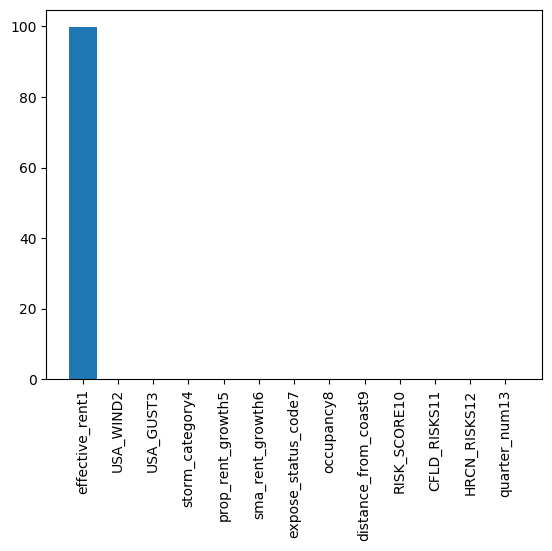

In [82]:
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.xticks(rotation=90)
plt.show()

In [83]:
# import seaborn as sns
# import pandas as pd
# from ctgan import CTGAN

# # Extract categorical data types
# cre_exposure = df_subset.loc[:, df_subset.columns.isin(numeric_features +  [ 'percent_change'])]
# cre_exposure['percent_change_category'] = cre_exposure['percent_change'].apply(categorize_percent_change)

# # Fit CTGAN
# ctgan = CTGAN(epochs=10)
# ctgan.fit(cre_exposure)

# # Generate the data
# synthetic_cre_exposure = ctgan.sample(20000)
# synthetic_cre_exposure.head()

In [84]:
# synthetic_cre_exposure = synthetic_cre_exposure.append(cre_exposure)

In [85]:
# synthetic_cre_exposure.shape

### Train-Test-Validate

In [86]:
### Train/Test/Validate Split

train_ratio = 0.80
test_ratio = 0.20



X = df_subset.loc[:, df_subset.columns.isin(numeric_features + ['percent_change'])]
y = df_subset.loc[:, df_subset.columns == 'percent_change_category']
# X = synthetic_cre_exposure.loc[:, synthetic_cre_exposure.columns.isin(numeric_features + ['percent_change'])]
# y = synthetic_cre_exposure.loc[:, synthetic_cre_exposure.columns == 'percent_change_category']

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
columns = numeric_features + ['percent_change']
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['percent_change_category'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['percent_change_category']==0]))
print("Number of subscription",len(os_data_y[os_data_y['percent_change_category']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['percent_change_category']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['percent_change_category']==1])/len(os_data_X))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=validation_ratio/(train_ratio+test_ratio))

print("Train:", os_data_X.shape)
# print("Validate:", X_test.shape)
print("Test:",os_data_y.shape)


length of oversampled data is  2940
Number of no subscription in oversampled data 980
Number of subscription 980
Proportion of no subscription data in oversampled data is  0.3333333333333333
Proportion of subscription data in oversampled data is  0.3333333333333333
Train: (2940, 14)
Test: (2940, 1)


In [87]:
# X = df_subset.loc[:, df_subset.columns.isin(numeric_features)]
# y = df_subset[ 'percent_change_category']

def class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    weight = dict()
    for i in keys:
        print(labels_dict[i])
        print(mu, total, float(labels_dict[i]))
        score = np.log(mu*total/float(labels_dict[i]))
        weight[i] = score if score > 1 else 1
    return weight
# random labels_dict
labels_dict = y.value_counts().to_dict()
weights = class_weight(labels_dict)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.20, random_state=42
# )

1238
0.15 1708 1238.0
425
0.15 1708 425.0
45
0.15 1708 45.0


### Data Augmentation (using SMOTE), Feature Scaling, and One-Hot Encoding

In [88]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

categorical_features = ["quarter_num"]

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

numeric_features_only = [
    "effective_rent", 
    'USA_WIND', 
    'USA_GUST',
    'storm_category',
    'prop_rent_growth', 'sma_rent_growth',
    'occupancy',
    "distance_from_coast",
    "RISK_SCORE", 
    "CFLD_RISKS",
    "HRCN_RISKS", 
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_only),
        ("cat", categorical_transformer, categorical_features)
    ]
)

### Modeling

In [89]:
## Logistic Regression
model = XGBClassifier(random_state=42)
pipe_lr = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("clf", LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs', max_iter=1000))]
)

## Random Forest
pipe_rf = Pipeline(
    steps = [("preprocessor", preprocessor), 
            ('clf', RandomForestClassifier(random_state=42))])

## Support Vector Machine
pipe_svm =Pipeline(
    steps = [("preprocessor", preprocessor), 
            ('clf', svm.SVC(random_state=42))
            ])

## XGBoost
pipe_xgb =Pipeline(
    steps = [("preprocessor", preprocessor), 
             ('clf',  XGBClassifier(random_state=42,))
            ])




In [90]:
# Set grid search params

param_range = clf__C=[0.00001, 0.0001, 0.001, 0.1, 10, 100, 1000]
param_range_fl = [1.0, 0.5]

grid_params_lr = [{'clf__penalty': ['l2'],
        'clf__C': param_range}] 


n_estimators = [25]
max_depth = param_range
min_samples_leaf = [2]
bootstrap = [True, False]

# n_estimators = [5, 10, 25, 50]
# max_depth = [25]
# min_samples_leaf = [25, 50, 75, 100]
# bootstrap = [True, False]

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': max_depth,
        'clf__min_samples_split': param_range[1:], 'clf__n_estimators' : n_estimators, 
        'clf__min_samples_leaf': min_samples_leaf, 'clf__bootstrap': bootstrap}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
        'clf__C': param_range}]

grid_params_xgb = [{
        'clf__kernel': ['linear', 'rbf'], 
        'clf__C': param_range,
        'clf__gamma': [0.5, 1, 1.5, 2, 5],

}]
# Construct grid searches
jobs = -1
CV = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)
scoring = make_scorer(recall_score, average = 'micro')
LR = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring=scoring,
            cv=CV) 

RF = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring=scoring,
            cv=CV, 
            n_jobs=jobs)


SVM = GridSearchCV(estimator=pipe_svm,
            param_grid=grid_params_svm,
            scoring=scoring,
            cv=CV,
            n_jobs=jobs)

XGB = GridSearchCV(estimator=pipe_xgb,
            param_grid=grid_params_xgb,
            scoring=scoring,
            cv=CV,
            n_jobs=jobs)

In [91]:
all_features = df_subset.loc[:, df_subset.columns.isin(numeric_features + ['percent_change'])]

In [92]:
scaler = StandardScaler()
X_os=os_data_X[numeric_features + ['percent_change']]
y_os=os_data_y['percent_change_category']

X_train, X_test, y_train, y_test = train_test_split(
    X_os, y_os, test_size=0.20, random_state=42
)

# X_train = X_train[numeric_features]
# X_test = X_test[numeric_features]

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_features)
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_features)

### Model Evaluation

In [93]:
# List of pipelines for iterating through each of them
grids = [RF]

# Creating a dict for our reference
grid_dict = {
    # 0: 'Logistic Regression', 
    # 1: 'XG Boost',
    0: 'Random Forest',
    # 3: 'Support Vector Machine',

}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(X_train, y_train)
    print('Best params are : %s' % gs.best_params_)
    # Best training data recall
    print(f'Best training {scoring}: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data recall of model with best params
    print(f'Test set {scoring} score for best params: %.3f ' % recall_score(y_test, y_pred, average='micro'))
    # Track best (highest test recall) model
    if recall_score(y_test, y_pred, average='micro') > best_acc:
        best_acc = recall_score(y_test, y_pred, average='micro')
        best_gs = gs
        best_clf = idx
    print(classification_report(y_test, y_pred, target_names=['greater than 3.5% annually', 'between 2.5% and  3.5% annually', 'between 0% and  2.5% annually']))
print(f'\nClassifier with best test set {scoring}: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file =f'best_params_simple{datetime.now().strftime("%Y%m%d-%H%M%S")}.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Random Forest
Best params are : {'clf__bootstrap': False, 'clf__criterion': 'entropy', 'clf__max_depth': 100, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 0.0001, 'clf__n_estimators': 25}
Best training make_scorer(recall_score, average=micro): 0.832
Test set make_scorer(recall_score, average=micro) score for best params: 0.855 
                                 precision    recall  f1-score   support

     greater than 3.5% annually       0.81      0.76      0.78       189
between 2.5% and  3.5% annually       0.97      0.98      0.97       205
  between 0% and  2.5% annually       0.78      0.82      0.80       194

                       accuracy                           0.86       588
                      macro avg       0.85      0.85      0.85       588
                   weighted avg       0.86      0.86      0.86       588


Classifier with best test set make_scorer(recall_score, average=micro): Random Forest

Saved Random 

In [94]:
from joblib import dump, load

suffix = datetime.now().strftime("%Y%m%d-%H%M%S")
estimator = gs.best_estimator_
dump(estimator, f"best_rf_tuned{suffix}.joblib")
estimator = load(f"best_rf_tuned{suffix}.joblib")


In [95]:
x_test_copy = X_test.copy()
x_test_copy['y_pred'] = y_pred
x_test_copy['y_test'] = y_test

In [96]:
x_test_copy['percent_change'] = X_os.iloc[x_test_copy.index]['percent_change']

In [97]:
x_test_copy[x_test_copy['y_pred'] != x_test_copy['y_test']]

,effective_rent,USA_WIND,USA_GUST,storm_category,prop_rent_growth,sma_rent_growth,expose_status_code,occupancy,distance_from_coast,RISK_SCORE,CFLD_RISKS,HRCN_RISKS,quarter_num,percent_change,y_pred,y_test
321,1278.000000,72.333333,100.000000,1.000000,0.010388,0.010642,2,0.934500,10.243621,27.211462,21.413088,47.487826,3,0.001565,0,2
495,1536.000000,64.666667,90.000000,1.000000,0.012209,0.007754,2,0.955000,3.567428,19.464110,16.711254,17.222500,3,-0.029297,0,2
785,1400.000000,61.000000,90.000000,1.000000,0.008644,0.008644,1,0.964700,58.483031,20.328942,1.779715,8.197344,3,0.021429,2,0
1173,1129.000000,97.333333,115.000000,3.000000,0.005570,0.005395,1,0.950000,29.470388,13.460283,15.630605,23.585659,4,0.010629,2,0
1178,1430.000000,103.500000,130.000000,3.000000,0.006726,0.006071,1,0.931200,64.475760,33.495147,1.988109,18.734920,4,0.044056,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,1442.000000,61.000000,90.000000,1.000000,0.011261,0.013490,2,0.964300,85.252999,33.495147,1.988109,18.734920,3,-0.000693,0,2
422,1232.000000,103.500000,130.000000,3.000000,0.003680,0.006071,1,0.951700,51.388414,33.495147,1.988109,18.734920,4,0.005682,0,2
509,1125.000000,103.500000,130.000000,3.000000,0.009499,0.008840,1,0.980000,54.475387,33.495147,1.988109,18.734920,4,0.028444,2,0
1831,1052.387942,98.420107,120.951834,2.768676,0.008803,0.007192,1,0.960081,9.792290,34.877028,31.007746,65.398082,3,0.048106,1,0


In [98]:
x_test_copy

,effective_rent,USA_WIND,USA_GUST,storm_category,prop_rent_growth,sma_rent_growth,expose_status_code,occupancy,distance_from_coast,RISK_SCORE,CFLD_RISKS,HRCN_RISKS,quarter_num,percent_change,y_pred,y_test
2313,933.468176,64.666667,90.000000,1.000000,0.010579,0.008987,2,0.940282,4.943178,18.711941,29.762816,15.359978,3,0.006932,1,1
650,1299.000000,103.500000,130.000000,3.000000,0.007009,0.006071,1,0.945000,44.687463,33.495147,1.988109,18.734920,4,0.033872,0,0
2350,1197.216102,80.156908,101.854776,1.948382,0.008093,0.006635,2,0.948658,23.130257,16.617149,15.619343,11.256961,3,0.007123,1,1
177,1018.000000,64.666667,90.000000,1.000000,0.008511,0.007754,3,0.965900,10.902517,19.464110,16.711254,17.222500,3,0.038310,0,0
2089,1519.958080,100.919559,120.545710,3.221828,0.006967,0.006966,1,0.939807,45.587026,13.183538,17.520303,8.264350,3,0.007141,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,1542.000000,64.666667,90.000000,1.000000,0.009153,0.008267,1,0.959800,74.736570,33.495147,1.988109,25.411357,3,-0.003243,2,2
1407,1505.378789,61.000000,90.000000,1.000000,0.009591,0.008267,1,0.936684,42.760116,33.495147,1.988109,18.734920,3,0.084373,0,0
962,1260.000000,93.250000,115.000000,2.000000,0.009919,0.010945,3,0.915800,14.472309,42.929143,31.166532,85.050491,3,-0.066667,2,2
2812,974.824462,67.137929,81.630096,1.000000,0.007400,0.006511,2,0.961529,43.011322,15.427466,2.599007,14.695260,3,0.007183,0,1


## TODO:

1. Analyze the False negatives. Are there any patterns to it?
2. Implement Ensemble Models

Starter Resources: https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html